# Training Cifar10 with PyTorch

## Training a Classifier

When dealing with images, text, audio or video data the data is loaded into a numpy array. Then this data is converted to a torch.*tensor

__torchvision__ is used for this training because it is auto loaded through torch. This includes common datasets including MNIST, ImageNet etc.

There are multiple images in Cifar10 including 'airplane', 'bird', 'cat' etc.

These images for Cifar10 are the size of 32x32x32 due to the 3-channel color images being 32x32 pixels in size.


The steps to completion are as follows.

1. Load and normalize the Cifar10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on this test data

## Load and Normalize Cifar10



In [1]:
# loaded with torchvision
import torch
import torchvision
import torchvision.transforms as transforms
import time

Output of torchvision datasets are PILImage images of range [0,1]. These are then transformed to Tensors of normalized range being [-1,1].

In [2]:
# Compose transformation
transform = transforms.Compose(
    [transforms.ToTensor(),     # to a tensor value
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])


# batch size is changed to 3 to see how it differs from what PyTorch themselves obtain in testing accuracy
batch_size = 5

# Downloading the images

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Display some training images for understanding and show.

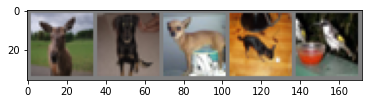

deer  dog   dog   dog   bird 


In [3]:
# imports for graphic and plotting
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def show_image(img):
    img = img / 2 + 0.5      # un-normalize the image
    norm_img = img           # what does it look like normalized?
    
    npimg = img.numpy()      # numpy image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
# get random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
show_image(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Now that we know that this works. We can begin to define our Convolutional Neural Network.

# Define a Convolutional Neural Network

This neural network copies the model from PyTorch Neural Networks section but is modified to take in 3-channel images.

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [4]:
# import torch neural network libraries
import torch.nn as nn
import torch.nn.functional as F


####################################################################################################################
# Information for the methods that are used in this section
# 
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, 
#                 bias=True, padding_mode='zeros', device=None, dtype=None)
#
# torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
#
# torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
#   --> Input features correspond to the size of each input sample
#   --> Output features correspond to the size of each output sample
#
# torch.nn.functional.relu(input, inplace=False)
#
####################################################################################################################


# setup class for the neural network building
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Three input channels for the 32x32 images in color
        self.conv1 = nn.Conv2d(3, 6, 5)   # in_channels = 3, out_channels = 6, kernel_size = 5
        
        self.pool = nn.MaxPool2d(2, 2)    # kernel_size and stride set to 2
        
        # input channels is the output of the last Conv2d
        self.conv2 = nn.Conv2d(6, 16, 5)  # in_channels = 6, out_channels = 16, kernel_size = 5
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    # feed forward
    def forward(self, x):
        
        # goes through in a forward manner
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except for batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

## Define a Loss function and an Optimizer

The loss function that is going to be used is a Classification Cross-Entropy loss and SGD with momentum.

In [5]:
import torch.optim as optim


####################################################################################################################
# torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=- 100, reduce=None, reduction='mean', 
#                           label_smoothing=0.0)
#
# torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False, 
# *, maximize=False, foreach=None, differentiable=False)
####################################################################################################################

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

## Train the Network

Now it is time to train the network since we have everything else set up. To do this, we loop over our data iterator, and feed the inputs to the network and optimize.

In [6]:
# start time
start_time = time.time()

for epoch in range(2):                            # loop over the dataset two times
    
    running_loss = 0.0                            # track loss
    for i, data in enumerate(trainloader, 0):
        
        # get inputs; data is a list of the inputs and labels [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward, backward and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print stats of the run
        running_loss += loss.item()
        
        # print even 2000 mini-batches
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            
            # set back to zero for the next mini-batch
            running_loss = 0.0                                                      
            
        
print('Finished Training')

# Get final time to test
print("\n--- %s seconds ---" % (time.time() - start_time))

/opt/conda/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


[1,  2000] loss: 2.232
[1,  4000] loss: 1.884
[1,  6000] loss: 1.642
[1,  8000] loss: 1.536
[1, 10000] loss: 1.465
[2,  2000] loss: 1.414
[2,  4000] loss: 1.382
[2,  6000] loss: 1.349
[2,  8000] loss: 1.316
[2, 10000] loss: 1.289
Finished Training

--- 107.61907911300659 seconds ---


Now that the model has been trained, it is important to save it. This is done below.

In [7]:
PATH = '/home/markaye/finn/notebooks/TorchCifar10/TrainedTorch.pth'

torch.save(net.state_dict(), PATH)

## Test the Network on The Test Data

Now the network has been trained for 2 passes over the training dataset. 
We must check to see if the network has learned anything at all. 

This is done by prediction. The class label is what is being predicted from the neural network output and from what we have assigned to the images. See what the accuracy is in classification. If the classification from the network is correct, the sample is added to a list of correct predictions.

First an image will be displayed with the assigned label for understanding.

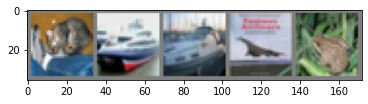

Correct Classification:  cat   ship  ship  plane frog 


In [13]:
# load an interation of data for testing
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
show_image(torchvision.utils.make_grid(images))

# show the classifications and images for the images
# not showing the testing yet
print("Correct Classification: ", ' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

Now we can go back to the saved model and test again this.

Model was saved previously for future use.

In [14]:
# load network
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

This output confirms to us that we have used the correct path and correct information.

Now we can see the output from the neural network.

In [15]:
outputs = net(images)

Outputs are the energies for the 10 classes. The higher the energy, the more the network associates the image with a particular class. 

A metric we want to know now is the image with the highest energy.

In [16]:
_, predicted = torch.max(outputs, 1)


# view the predictions
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(5)))

Predicted:  cat   ship  ship  ship  frog 


Now we can see how the network performed when going through the whole network. 
Additionally, we can get an accuracy over all of the images. 


Moreover, we are going to see which classes performed the best. Assuming that we get a good accuracy, we can see what the network was best at identifying.

In [17]:
start_time = time.time()

# counters to check for error
correct_images = 0
total_images = 0

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


# no gradient since we are not training
with torch.no_grad():
    
    for data in testloader:
        
        images, labels = data
        
        # calculate the outputs by running the images through the network
        outputs = net(images)
        
        # class with the highest energy is what was chosen for the prediction
        _, predicted = torch.max(outputs.data, 1)
        _, indv_predictions = torch.max(outputs, 1)
        
        total_images += labels.size(0)
        
        # correct if the prediction equals the correct label
        correct_images += (predicted == labels).sum().item()
        
        # correct predictions from each class
        for label, pred in zip(labels, indv_predictions):
            if label == pred:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        
        
# print output to see the accuracy
print(f'Accuracy of the network on the 10000 test images: {100 * correct_images // total_images} % \n')

# individual predictions
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    
    # print for each indv class
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f}%')

# Get final time to test
print("\n--- %s seconds ---" % (time.time() - start_time))


Accuracy of the network on the 10000 test images: 54 % 

Accuracy for class: plane is 52.3%
Accuracy for class: car   is 68.0%
Accuracy for class: bird  is 27.7%
Accuracy for class: cat   is 47.1%
Accuracy for class: deer  is 51.9%
Accuracy for class: dog   is 31.1%
Accuracy for class: frog  is 69.8%
Accuracy for class: horse is 55.5%
Accuracy for class: ship  is 80.5%
Accuracy for class: truck is 63.0%

--- 4.492564916610718 seconds ---


This is much better than the random chance which would be about 10% when choosing between 10 images. 